In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np
from matrix_creation import polynomial_features, standard_scaler,scale_features_by_intercept_use
from main_methods import OLS_parameters, Ridge_parameters, gradient_descent_OLS, gradient_descent_ridge, sklearn_lasso_regression
from errors import MSE,R2


In [2]:
from plotting_exploration import plot_mse,plot_r2, explore_lambda, explore_polynomial_degree, lasso_grid_search, plot_heatmap_lasso, plot_theta_by_polynomials


In [11]:
# Runge's function - parameters to explore

n_datapoints = 50 # changed and ran code with different values. Could have been implemented as a list and looped over, but regarded as not necessary.
standard_deviation = 0.1 # for noise, should we play around with this values as well in analysis?
p = 15 # polynomial degree

lambda_range = (-1,-5) # range of lambda values for np.log
lambda_n = 50 # number lambda values to explore
lambdas_start = np.logspace(lambda_range[0],lambda_range[1],lambda_n) # lambdas generated in logspace for learning rate

# Grid search
etas = [0.001, 0.005, 0.01, 0.05, 0.1] # gradient descent parameters

# tolerance criteria for gradient descent methods
tolerance = 1e-6
max_iterations = 1000

# changed to variable to easily switch between True and False for fit_intercept
use_intercept = True 

# create plots or not
create_plots = True

verbose_bool = False

np.random.seed(250)  # ensure reproducibility

# generating data without noise
x = np.linspace(-1, 1, num=n_datapoints)
y = 1 / (1 + 25 * x**2)

# generating data with noise
#x_noise = np.linspace(-1, 1, num=n_datapoints) + np.random.normal(0, standard_deviation, n_datapoints)
#y_noise = 1 / (1 + 25 * x_noise**2)
x_noise = x
y_noise = 1 / (1 + 25 * x_noise**2) + np.random.normal(0, standard_deviation, n_datapoints)

Baseline with OLS for comparison of other regressions
sklearn OLS not scaled. Coef: [ 0.00000000e+00  7.90498768e-02 -1.54594672e+01 -3.81008474e+00
  1.33214806e+02  5.01615004e+01 -6.07555408e+02 -2.85785016e+02
  1.52171271e+03  8.23376073e+02 -2.09760334e+03 -1.25142427e+03
  1.48726986e+03  9.53487340e+02 -4.22495258e+02 -2.86083986e+02], intercept: 0.9537476743745883 
sklearn OLS scaled. Coef: [ 0.00000000e+00  4.46833023e-02 -4.76029573e+00 -1.46360701e+00
  3.84851319e+01  1.62944230e+01 -1.64636610e+02 -8.41806111e+01
  3.92364949e+02  2.27191770e+02 -5.20676343e+02 -3.29546055e+02
  3.58580296e+02  2.42536825e+02 -9.96093202e+01 -7.08815766e+01], intercept: 0.28636302300702693 



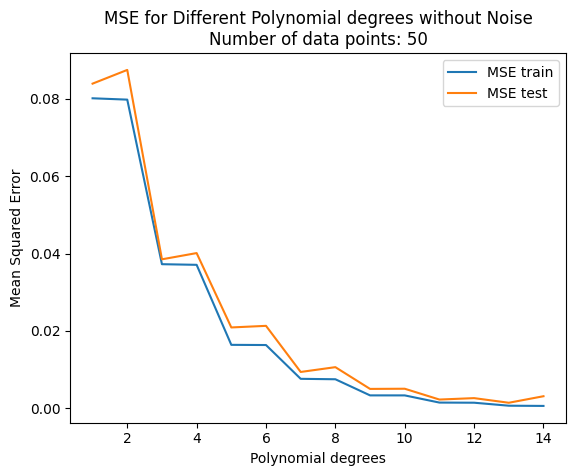

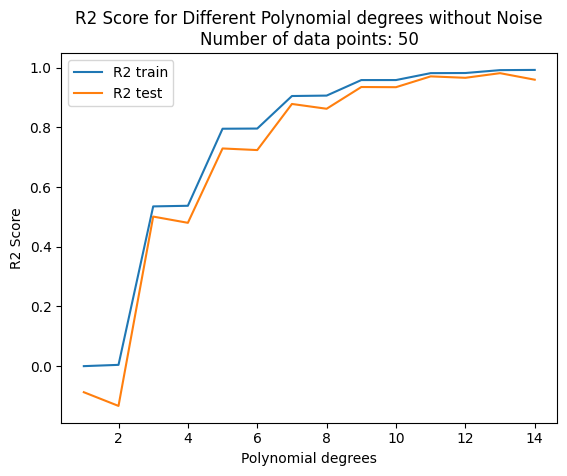

50 50 50


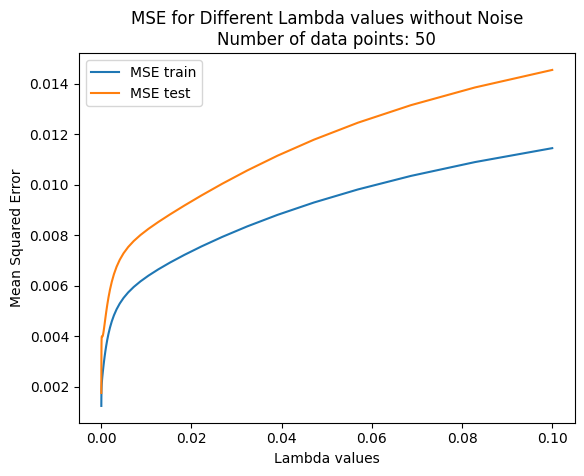

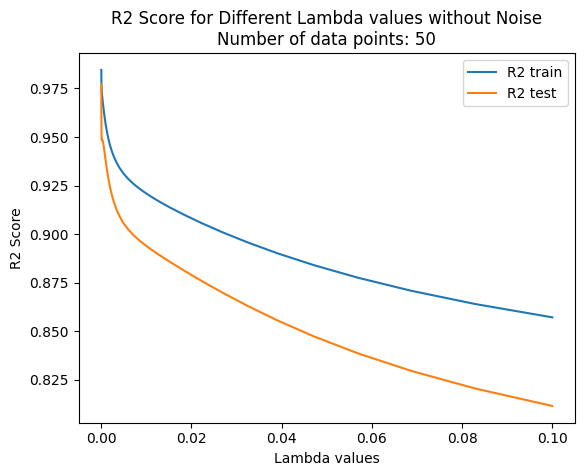

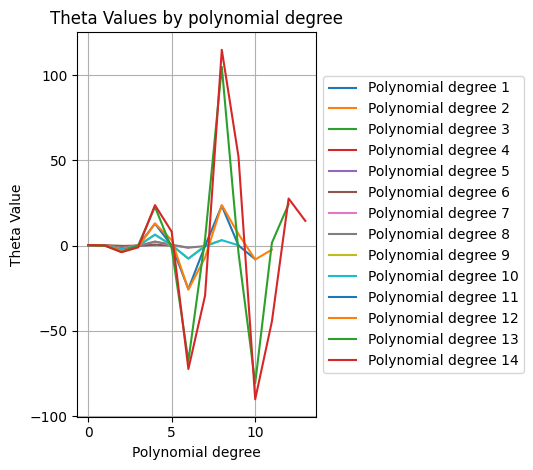

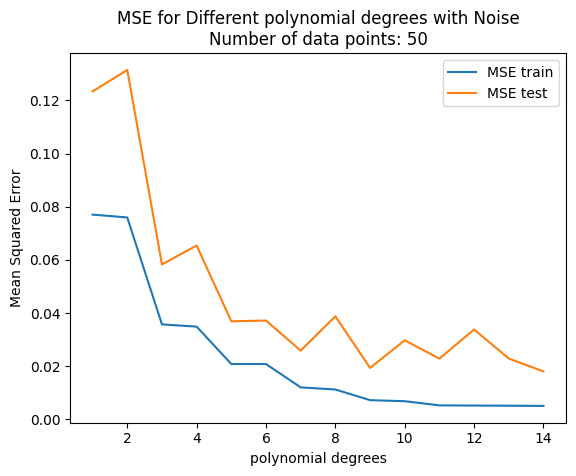

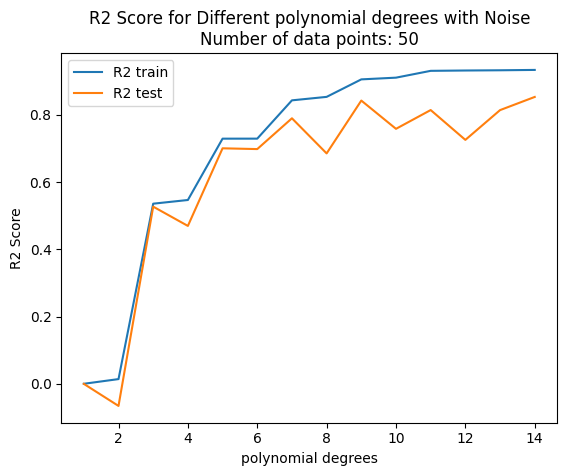

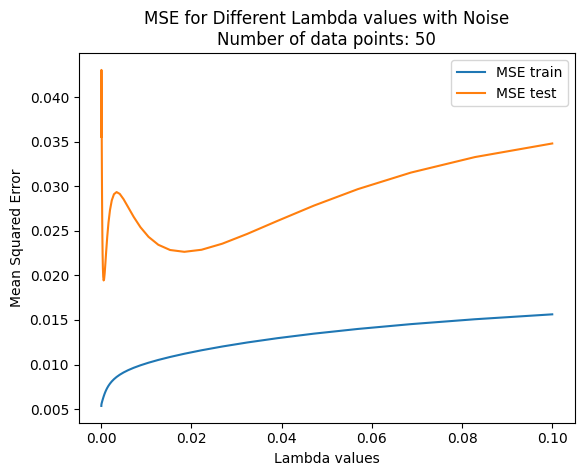

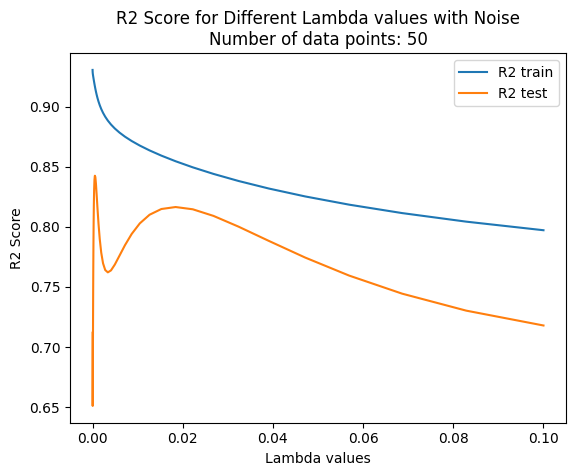

(50, 5)


<Figure size 600x400 with 0 Axes>

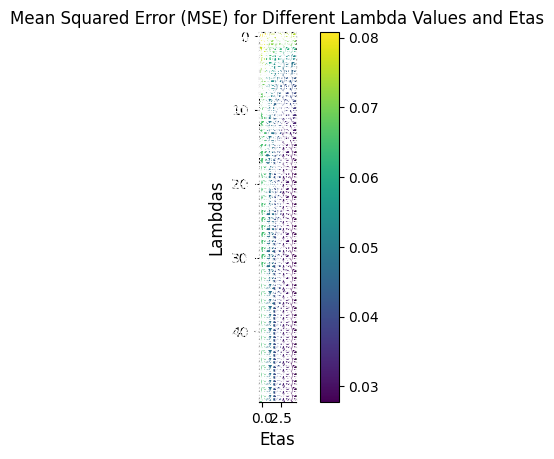

c:\Users\brumor\AppData\Local\miniconda3\envs\4155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.540e-03, tolerance: 3.204e-06
  model = cd_fast.enet_coordinate_descent(


In [12]:
# Runge's function analysis
##################################################


# OLS as function of polynomial degree
# No noise
# creating design matrix with polynomial features: p
X = polynomial_features(x, p,intercept=use_intercept) # intercept=True gives intercept column = 0 in standard scaler if intercept is True, and hence division by 0. 

# test and train dataset, and scaling of X_train and X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_scaled, X_test_scaled = scale_features_by_intercept_use(X_train, X_test, use_intercept)

# Calcualte OLS with sklearn as baseline values of intercept and theta
# Compare other regression results to this
ols_model_not_scaled = LinearRegression(fit_intercept=use_intercept)
ols_model_scaled = LinearRegression(fit_intercept=use_intercept)
ols_sklearn_not_scaled = ols_model_not_scaled.fit(X_train, y_train)
ols_sklearn_scaled = ols_model_scaled.fit(X_train_scaled, y_train)
print("Baseline with OLS for comparison of other regressions")
print(f"sklearn OLS not scaled. Coef: {ols_sklearn_not_scaled.coef_}, intercept: {ols_sklearn_not_scaled.intercept_} ")
print(f"sklearn OLS scaled. Coef: {ols_sklearn_scaled.coef_}, intercept: {ols_sklearn_scaled.intercept_} \n")


# scaled data for features as input 
polynomial_degree, mse_train, mse_test, r2_train, r2_test, thetas = explore_polynomial_degree(X_train_scaled, X_test_scaled, y_train, y_test, p, use_intercept=use_intercept, verbose=verbose_bool)
if create_plots:
    plot_mse(n_datapoints, polynomial_degree,"Polynomial degrees", mse_train, mse_test, noise=False)
    plot_r2(n_datapoints, polynomial_degree,"Polynomial degrees", r2_train, r2_test, noise=False)
# Explore lambdas with Ridge regression - no noise

lambdas, mse_train_ridge, mse_test_ridge, r2_train_ridge, r2_test_ridge = explore_lambda(X_train_scaled, X_test_scaled, y_train, y_test, lambdas_start, verbose=verbose_bool)
if create_plots: #MSE and R2 with no noise
    print(len(mse_train_ridge), len(lambdas), len(mse_test_ridge))
    plot_mse(n_datapoints, lambdas,"Lambda values", mse_train_ridge, mse_test_ridge, noise=False)
    plot_r2(n_datapoints, lambdas,"Lambda values", r2_train_ridge, r2_test_ridge, noise=False)

# Plot theta values as function if polynomial degree
#               ------>   should we use with or without noise?
plot_theta_by_polynomials(thetas)

# OLS with noise
# creating design matrix with polynomial features: p
X_noise = polynomial_features(x_noise, p,intercept=use_intercept) # intercept=True gives intercept column = 0 in standard scaler if intercept is True, and hence division by 0. Leaving intercept out since Ridge regression handles this

# test and train dataset, and scaling of X_train and X_test
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_noise, y_noise, test_size=0.2)
X_train_scaled_noise, X_test_scaled_noise = scale_features_by_intercept_use(X_train_noise, X_test_noise, use_intercept)

# scaled data for features as input 
polynomial_degree, mse_train, mse_test, r2_train, r2_test, thetas = explore_polynomial_degree(X_train_scaled_noise, X_test_scaled_noise, y_train_noise, y_test_noise, p, use_intercept=use_intercept, verbose=verbose_bool)
if create_plots: #MSE and R2 with noise
    plot_mse(n_datapoints, polynomial_degree, "polynomial degrees", mse_train, mse_test, noise=True)
    plot_r2(n_datapoints, polynomial_degree, "polynomial degrees",r2_train, r2_test, noise=True)


# Explore lambdas with Ridge regression - noise
lambdas, mse_train_ridge, mse_test_ridge, r2_train_ridge, r2_test_ridge = explore_lambda(X_train_scaled_noise, X_test_scaled_noise, y_train_noise, y_test_noise, lambdas_start, verbose=verbose_bool)
if create_plots:
    plot_mse(n_datapoints, lambdas,"Lambda values", mse_train_ridge, mse_test_ridge, noise=True)
    plot_r2(n_datapoints, lambdas,"Lambda values", r2_train_ridge, r2_test_ridge, noise=True)



##################################################
# Explore Lasso regression as function of lambdas and learning rate
verbose_lasso = False
lasso_grid, lasso_mse_train, lasso_mse_test, lasso_r2_train, lasso_r2_test, mse_values = lasso_grid_search(X_train, X_test, y_train, y_test, lambdas_start, etas, tolerance, max_iterations, use_intercept, verbose=verbose_bool)
if create_plots:
    plot_heatmap_lasso(mse_values, lambda_n, etas)
# compare with lasso sklearn - use alpha value from own implementation and calculation of lasso, best value
#                     --------> use lambda_ or learning rate, or a constant? Unsure about the calculated intercept value
if verbose_bool: print('lasso - not scaled')
sklearn_lasso_regression(X_train, y_train, lasso_grid['lambda'], use_intercept, max_iterations, tolerance, verbose=verbose_bool)
if verbose_bool: print('lasso - scaled')
sklearn_lasso_regression(X_train_scaled, y_train, lasso_grid['lambda'], use_intercept, max_iterations, tolerance, verbose=verbose_bool)




# About scaling - information for report

See "machine learning with Python and Scikit-learn - page 119-122" and https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section.
From scikit documentation handling of outliers are important when scaling. Standard scaler is not robust to outliers, men our dataset is generated with some noise but no outliers. Standard scaler is hence ok to use, and mean and variance is mentioned. Write arguement for using standard scaler and not normaliazation.

From lecture notes: 

The StandardScaler function in Scikit-Learn ensures that for each feature/predictor we study the mean value is zero and the variance is one (every column in the design/feature matrix). This scaling has the drawback that it does not ensure that we have a particular maximum or minimum in our data set.

The Normalizer scales each data point such that the feature vector has a euclidean length of one. In other words, it projects a data point on the circle (or sphere in the case of higher dimensions) with a radius of 1. 
This means every data point is scaled by a different number (by the inverse of it’s length). This normalization is often used when only the direction (or angle) of the data matters, not the length of the feature vector.

The RobustScaler works similarly to the StandardScaler in that it ensures statistical properties for each feature that guarantee that they are on the same scale. 
However, the RobustScaler uses the median and quartiles, instead of mean and variance. This makes the RobustScaler ignore data points that are very different from the rest (like measurement errors). 
These odd data points are also called outliers, and might often lead to trouble for other scaling techniques.